In [1]:
pip install gensim==3.8.3

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Importing the libiraries
import gensim


#check Gensim version
assert '3.8.2' <= gensim.__version__ <= '3.8.3', 'You must install Gensim 3.8.3 or 3.8.2 to be able to run LDA Mallet'


from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaModel

import pandas as pd
import numpy as np


import math
import sys

import matplotlib.pyplot as plt

import pickle

from scipy.spatial.distance import jensenshannon
# try:
# 	from hungarian_algorithm import algorithm
# except:
# 	print('You need to install "hungarian_algorithm" package to run this code')
# 	exit()


# from post_processing import jaccard_sim, dice_sim, similarity_computation
# from pre_processing import loading_wiki_docs, prepare_corpus, preprocess_data, term_pairs_generator

# from diskcache_class import db

import platform 
#checking OS
if 'windows' in platform.system().lower():
	mallet_path = 'c:/mallet-2.0.8/bin/mallet'
elif 'linux' in platform.system().lower():
    import os
    os.environ['MALLET_HOME'] = 'mallet-2.0.8/'
    mallet_path = 'mallet-2.0.8/bin/mallet' # you should NOT need to change this
#     os.environ['MALLET_HOME'] = '../mallet-2.0.8/'
#     mallet_path = '../mallet-2.0.8/bin/mallet' # you should NOT need to change this 
else:
	mallet_path = 'mallet'

/home/zha219/.local/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# !unzip mallet-2.0.8.zip

# pre-process the documents

In [3]:
#pre-processing 
#this part uses Amin's code 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim import similarities



import csv, sys
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


import pandas as pd
import numpy as np

import copy


try:
	csv.field_size_limit(sys.maxsize)
except:
	print('Error in setting maxSize for CSV output')
    
def preprocess_data(doc_list, id_list, extra_stopwords = {},len_th=4,lemmatized=False):
	'''
	Returns: a list of process dataset and origianl documents of those documents

	This function removes stop-wrods, lemmatized the documens, if stated, and eliminates the documnets 
	with lenhgth of 4 or less. 
	***These processes may result in lower number of documents than the original number. To make sure 
	you receive both the original docs and the processed doc in similar order we return both.

	parameter doc_list: a list of string (documents)
	parameter extra_stopwords: NLTK.stop_words are used, if you wish to add to that list, you can use yours.
	parameter len_th: documents with len_th and less will be removed.
	parameter lemmatized: If true, the terms will be lemmatized. **be aware that lemmatization of the documents
	will result in different topics and may need different evaluation, including NPMI, stability, or human assessment**

	'''

	# replace single smart quote with single straight quote, so as to catch stopword contractions
	doc_list = [re.sub("[\u2018\u2019]", "'", doc) for doc in doc_list]
	doc_list = [re.sub('\d+', '', doc) for doc in doc_list]
	doc_list = [re.sub('(\/.*?\.[\w:]+)', '', doc) for doc in doc_list]
	#doc_list = [re.sub('pdf|icon|jpg', '', doc) for doc in doc_list]
	#doc_list = [re.sub('(http(s)?:\/\/.)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)', '', doc) for doc in doc_list]
	doc_list = [re.sub(r"http\S+", '', doc) for doc in doc_list]

	# initialize regex tokenizer
	tokenizer = RegexpTokenizer(r'\w+')
	# create English stop words list
	en_stop = set(stopwords.words('english'))
	# add any extra stopwords
	if (len(extra_stopwords) > 0):
		en_stop = en_stop.union(extra_stopwords)

	#defining a lemmatizer
	lemmatizer = WordNetLemmatizer()

	# list for tokenized documents in loop
	texts = []
	original_docs = []
	# loop through document list
	c = 0 #counter on the document number
	for i in doc_list:
		# clean and tokenize document string
		raw = i.lower()
		tokens = tokenizer.tokenize(raw)
		stopped_tokens = []
		# remove stop words from tokens
		#stopped_tokens = [i for i in tokens if not i in en_stop and len(i)>1]
		if lemmatized:
		  for t in tokens:
		    if t not in en_stop and len(t)>1:
		      pos=nltk_tag_to_wordnet_tag(nltk.pos_tag([t])[0][1])
		      if pos:
		        stopped_tokens.append(lemmatizer.lemmatize(t,pos=pos))
		      else:
		        stopped_tokens.append(lemmatizer.lemmatize(t))
		  #     print(t,pos,nltk.pos_tag([t])[0][1])
		  # print(stopped_tokens)
		  #stopped_tokens = [lemmatizer.lemmatize(i,pos=nltk_tag_to_wordnet_tag(nltk.pos_tag([i])[0][1])) for i in tokens if not i in en_stop and len(i)>1]
		else:
		  stopped_tokens = [i for i in tokens if not i in en_stop and len(i)>1]


		# add tokens to list
		if len(stopped_tokens) >= len_th:
		  texts.append([stopped_tokens, i, id_list[c]]) # [pre-processed text (tokenized), original, id]
		  #original_docs.append([i,c])

		c += 1

	return texts

[nltk_data] Downloading package stopwords to /home/zha219/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/zha219/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zha219/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/zha219/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Store the 2020 tweets in a seperate csv file


In [11]:
# #filter data for 2020
# import csv
# with open('../2020tweets.csv','w') as csvwrite:
#     writer = csv.writer(csvwrite)
#     with open("../tweets_scraped.csv", "r") as csvfile:
#             csv_content = csv.reader(csvfile,delimiter = ',')
#             # next
#             c = 0
#             for row in csv_content:
#                 if c==0:
#                     writer.writerow(row)
#                     continue
#                 temp = row[2].split('-')[0]
#                 if temp =='2020':
#                     writer.writerow(row)

## filter the 2020 data to have at least one attention...

In [22]:

# filter the 2020 data to have at least one attention... 
# int(row[8])+int(row[9])+int(row[10])+int(row[11])>=1
# from tqdm import tqdm
# import csv


# c = 0
# doclist = []
# with open('2020publicTweetsPlusOneAttention.csv','w') as csv_writer:
#     writer = csv.writer(csv_writer)
#     with open('2020publicTweets.csv','r') as csvfile:
#         csvreader = csv.reader(csvfile)
#         for row in tqdm(csvreader):
#             # print(row)
#             # break
#             try:
#                 if c==0 or int(row[8])+int(row[9])+int(row[10])+int(row[11])>=1:
#                     writer.writerow(row)
#                     c+=1
#             except:
#                 continue

# Set the stop words

In [2]:
#read all the stop words and add them to the list of extra stop words..
extra_stop_words = open('Stopword_list', 'r')
#addiong some stop words...
extra_stop_words_list = extra_stop_words.readlines()
extra_stopwords = set()
for item in extra_stop_words_list:
    extra_stopwords.add(item.strip())
extra_stopwords.add('amp');extra_stopwords.add('&amp');extra_stopwords.add('&amp;')

# print(extra_stopwords)


In [3]:
import pickle

# Load the wiki vocab and dict for coherence  and update Stop words

In [7]:
with open('wiki_vocab_dict','rb') as read_file:
    wiki_vocab_dict = pickle.load(read_file)

with open('vocab_dict', 'rb') as read_file:
    vocab_dict = pickle.load(read_file)

In [8]:
# set(vocab_dict.token2id.keys())
extra_stopwords = extra_stopwords.union(set(vocab_dict.token2id.keys()).difference(set(wiki_vocab_dict.token2id.keys())))

In [3]:
#NO NEED TO RUN THIS ANYMORE
# load the pre-processed documents and preprocess the original documents:
# import csv
# from tqdm import tqdm

# doclist = []
# # with open('preprocessed.csv', 'r') as csvfile:
# with open('preprocessed2020.csv', 'r') as csvfile:
#     csvreader = csv.reader(csvfile)
#     for row in tqdm(csvreader):
#         texts = preprocess_data([row[1]], [row[2]], extra_stopwords,len_th=4,lemmatized=False) #[pre-processed text (tokenized), original, id]
#         doclist.append(texts[0][0])

# print('{0} number of documents are loaded. '.format(len(doclist)))


13686023it [31:51, 7474.96it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

23828625it [55:00, 7218.80it/s]

23828625 number of documents are loaded. 


In [30]:
# import pickle

# with open('preprocessed2020doclist','wb') as save_file:
#     pickle.dump(doclist,save_file)

In [6]:
import pickle

with open('preprocessed2020doclist','rb') as read_file:
    doclist = pickle.load(read_file)

In [7]:
#import original documents
import csv
from tqdm import tqdm
completedocs = []
with open('preprocessed2020.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in tqdm(csvreader):
        originaltext.append(row[1])

0it [00:00, ?it/s]


NameError: name 'originaltext' is not defined

In [32]:
#import all documents
import csv
from tqdm import tqdm
import re
completedocs = []
with open('preprocessed2020.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    c = 0
    for row in tqdm(csvreader):
        completedocs.append([re.findall("\w+",row[0]), row[1], row[2]])

12070252it [06:58, 28812.42it/s]


In [33]:
#subsample 10 % from 2020 tweets
from random import sample
import random

random.seed(123456)
sample_size = int(len(completedocs)*.10)
completedocssampled = sample(completedocs,sample_size)
doclist = [item[0] for item in completedocssampled] #doclist is a list of list
originaltext = [item[1] for item in completedocssampled]#originaltext is a list of

In [5]:
del completedocs

In [10]:
#saving the sample documents:
with open('completedocssampled.obj', 'wb') as objwriter:
    pickle.dump(completedocssampled, objwriter)

In [1]:
# len(doclist), len(originaltext)#, len(completedocs)
# doclist[1:4], originaltext[1:4]

### subsample 10 % from 2020 tweets


In [86]:
#subsample 10 % from 2020 tweets
# from random import sample
# import random

# random.seed(123456)
# # sample_size = int(len(doclist)*.10)
# sample_size = 1000000
# doclist = sample(doclist,sample_size)

# random.seed(123456)
# # sample_size = int(len(originaltext)*.10)
# sample_size = 1000000
# originaltext = sample(originaltext, sample_size)

In [90]:
len(doclist), len(originaltext)

(193, 193)

In [18]:
#create a hashmap for keeping the source name (i.e., corpus name)
# source_dic = {
#     (0, len(doclist)-1) : 'public_tweets'
# }

In [8]:
#preprocess the news media tweets..

# from tqdm import tqdm

# news_media_files = ['tweets_nytimes.csv', 'tweets_WSJ.csv','tweets_USATODAY.csv'] 

# for newsName in news_media_files:
#     a = len(doclist)
#     with open(newsName,'r') as csvfile:
#             csvreader = csv.reader(csvfile)
#             next(csvreader)
#             doclistNews, idlistNews = [], []
#             for row in tqdm(csvreader):
#                 doclistNews.append(row[7])
#                 idlistNews.append(row[4])
            
#             #call the pre-processing
#             texts = preprocess_data(doclistNews, idlistNews, extra_stopwords = {},len_th=4,lemmatized=False)
#             for item in texts:
#                 doclist.append(item[0])
                   
#     b = len(doclist)
#     source_dic[(a, b)]=newsName.split('.')[0]
    
    

12976it [00:00, 51264.81it/s]
7672it [00:00, 64117.73it/s]
5930it [00:00, 53043.77it/s]


### prepare the corpus to construct the ditionary and the doc-term matrix 

In [4]:
def prepare_corpus(doc_clean,no_below=5,no_above=0.5):
	'''
	Reutrns: A dictionary of the final set of terms and document-term frequency matrix

	# adapted from https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

	parameter doc_clean: processed set of documents (type: string)
	parameter no_below: exclude words that only appear $no_below$ times or less in the whole corpus
	parameter no_above: any words included in more than $no_above$ percentage of documents will be excluded

	'''
	# Creating the term dictionary of our courpus, where every unique term is assigned an index.
	dictionary = corpora.Dictionary(doc_clean)

	dictionary.filter_extremes(no_below=no_below, no_above=no_above)
	# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
	doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
	# generate LDA model
	return dictionary,doc_term_matrix

In [73]:
# vocab_dict, doc_term_matrix = prepare_corpus(doclist)
# N = int(len(doclist)/1000)
vocab_dict, doc_term_matrix = prepare_corpus(doclist)

In [84]:
# doc_term_matrix, vocab_dict

In [124]:
# import pickle

# with open('vocab_dict','wb') as save_file:
#     pickle.dump(vocab_dict,save_file)
        
# with open('doc_term_matrix','wb') as save_file:
#     pickle.dump(doc_term_matrix,save_file)

### Coherence Computing function to find the best number of topics

In [17]:
def compute_coherence_values(dictionary, corpus, texts, ref_dict=[], limit=25, start=5, step=5,threshold=0.10,runs = 1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    purity_values: Average purity for each run
    contrast_values: Average of contrast for each run
    df: DataFrame df inlcudes all results and number of topics associated with those results
    """
    coherence_values = []
    coherence_std = []
    model_list = []
    purity_values = []
    contrast_values = []
    all_top_terms = []#this list will store all topics of all models as a list of top terms.
    # so with two models one with 10 and one with 20, we will have 30 of top terms
    top_terms_count_ls = [0] #this list keeps track of topics we add in each run and for each num_topics
    df = pd.DataFrame(columns=['num_topics','coherence','purity','contrast'])
    for num_topics in range(start, limit+1, step):
      model_t = []
      purity_t = []
      coherence_t = []
      contrast_t = []
      for r in range(runs):
          #model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
          model = LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary,optimize_interval = 25,iterations=2000, workers = 6) # only add it on server and not local 
          #model_t.append(model)

          #storing top_terms
          for tn in range(num_topics): 
          	tt = model.show_topic(tn,topn=20)
          	#saving top_terms and their counts
          	all_top_terms.append([i[0] for i in tt])
				  #saving counts of top_terms
          top_terms_count_ls.append(len(all_top_terms))

          #purity computation
#           topic_term_cond = get_conditional_probabilities(model,num_topics)
          topic_term = model.get_topics()#model.show_topics(num_topics = num_topics, num_words=200)
          #go over each topic and compute set of words that satisfy p(t|w)>=threshold
          pur = []
          cont = []
          for t in range(num_topics):
            pur.append(0.0)
            cont.append(0.0)
#             w_ind = np.argwhere(topic_term_cond[t,:]>=threshold)
#             pur.append(np.sum(topic_term[t,w_ind]))
#             cont.append(np.mean(topic_term_cond[t,w_ind]))
          
          #for n in range(num_topics):
            #pur.append(sum([float(i) for i in re.findall(r'\d*\.\d+',topic_term[n][1]) if float(i)>=threshold]))

          purity_t.append(np.mean(pur))
          contrast_t.append(np.mean(cont))
          # coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_npmi',processes=1)
          # coherence_value = coherencemodel.get_coherence()
          # coherence_t.append(coherence_value)
          df = df.append({'num_topics':num_topics,'purity':np.mean(pur),'contrast':np.mean(cont)},ignore_index=True)

        #stroing the results
#       model_list.append(model)
      purity_values.append(purity_t)
      #coherence_values.append(coherence_t)
      contrast_values.append(contrast_t)
      print('{0} number of topics has been processed'.format(num_topics))

    #computing coherence for all top terms at once
    cscore = CoherenceModel(topics=all_top_terms,dictionary=ref_dict,texts=texts,coherence='c_npmi',processes=7).get_coherence_per_topic() #processes are the number of threads in computing coherence

    for i in range(0,len(top_terms_count_ls)-1):
    	coherence_values.append(np.mean(cscore[top_terms_count_ls[i]:top_terms_count_ls[i+1]]))
    	coherence_std.append(np.std(cscore[top_terms_count_ls[i]:top_terms_count_ls[i+1]]))
    	#update dataframe
    df.coherence = coherence_values
    df['coherence_std'] = coherence_std
    return model_list, coherence_values, purity_values, contrast_values,df

In [126]:
# #2.1 function to load wikipedia corpus
# def loading_wiki_docs(filename:str):
# 	'''
# 	Returns: documents of wikipedia corpus

# 	loads a wikipedia text file and return documents with length>3

# 	parameter filename: name of the wikipedia text documents (type:str)
# 	'''
# 	wiki_docs = []

# 	with open(filename,'r',encoding="utf-8") as f:
# 	    d = f.readline()
# 	    wiki_docs.append(d)
# 	    while(d):
# 	      d = f.readline()
# 	      if len(d) > 3:
# 	        wiki_docs.append(d)
# 	return wiki_docs

In [ ]:
#2.2 load wikipedia for coherence computing
#topic coherence
# wiki_docs = loading_wiki_docs('../wiki_corpus/wiki_full')
#doing pre-processing on wiki-pedia documents
# pre_processed_wiki = preprocess_data(wiki_docs,[0]*len(wiki_docs))
# pre_processed_wiki = [i[0] for i in pre_processed_wiki]
# wiki_vocab_dict, _ = prepare_corpus(pre_processed_wiki)
# del wiki_docs

In [17]:
# import pickle

# with open('pre_processed_wiki','wb') as save_file:
#     pickle.dump(pre_processed_wiki,save_file)
        
# with open('wiki_vocab_dict','wb') as save_file:
#     pickle.dump(wiki_vocab_dict,save_file)

In [12]:
# impodoc_term_matrixe
with open('pre_processed_wiki','rb') as read_file:
    pre_processed_wiki = pickle.load(read_file)
        
with open('wiki_vocab_dict','rb') as read_file:
    wiki_vocab_dict = pickle.load(read_file)

with open('doc_term_matrix', 'rb') as read_file:
    doc_term_matrix = pickle.load(read_file)

with open('vocab_dict', 'rb') as read_file:
    vocab_dict = pickle.load(read_file)

In [13]:
from random import sample
import random
random.seed(123456)
wiki_sample_size = int(len(pre_processed_wiki)*.05)

pre_processed_wiki = sample(pre_processed_wiki,wiki_sample_size)

In [14]:
len(pre_processed_wiki)

265112

In [22]:
import seaborn as sns
def plotting_coherence(eval_df):
    ax =sns.pointplot(x='num_topics', y='coherence', data=eval_df)
    plt.title('Coherence score with Wiki docs as ref corpus')
    plt.show()
    ax = plt.errorbar(x='num_topics', y='coherence', yerr='coherence_std', data=eval_df[0:-1:3])
    plt.title('Coherence score with std within a single run')
    plt.show

ImportError: /home/amh418/.local/lib/python3.8/site-packages/scipy/cluster/_vq.cpython-38-x86_64-linux-gnu.so: failed to map segment from shared object

In [23]:
#3.run the LDA for the nuber of topics documents found above
from random import sample
import random
random.seed(123456)
lim = 40
st = 40
stp = 2
n_runs = 2
sample_size = 1000000
models, coherence, pur, cont,eval_df = compute_coherence_values(dictionary=vocab_dict, corpus=doc_term_matrix, texts=pre_processed_wiki,ref_dict=wiki_vocab_dict, limit=lim, start=st, step=stp,threshold=0.10,runs = n_runs)
#running on a VM machine
# eval_df.to_csv('coherence_ap_10to90.csv',index=False)
# plotting_coherence(eval_df)
eval_df.to_csv('coherence_{0}to{1}_st{2}.csv'.format(st,lim,stp))

Mallet LDA: 40 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 63
total tokens: 14806973
<10> LL/token: -11.96896
<20> LL/token: -11.79058
<30> LL/token: -11.63038
<40> LL/token: -11.34001

0	1.25	coronavirus people today health pandemic lockdown time support test home testing care work news good masks free message safe stay 
1	1.25	coronavirus trump florida election texas vote person oct georgia nov helps arizona state start voting people days health pandemic overcome 
2	1.25	coronavirus pandemic people health day lockdown time stay safe fight crisis today world due virus week country read spread india 
3	1.25	coronavirus people pandemic lockdown virus news stay home today time love world mask quarantine health social day back worth holiday 
4	1.25	vaccine coronavirus vaccines pandemic pfizer trial drug support crisis health work doses research time women care clinical world people important 
5	1.25	coronavirus today state health positive people update county tested i

40 number of topics has been processed


/share/ceph/scratch/amh418/9576375/ipykernel_2547623/988612874.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'num_topics':num_topics,'purity':np.mean(pur),'contrast':np.mean(cont)},ignore_index=True)


In [24]:
eval_df

,num_topics,coherence,purity,contrast,coherence_std
0,40.0,0.052532,0.0,0.0,0.031614
1,40.0,0.054608,0.0,0.0,0.035701


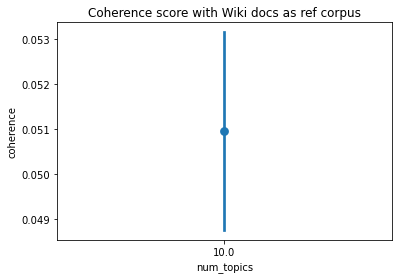

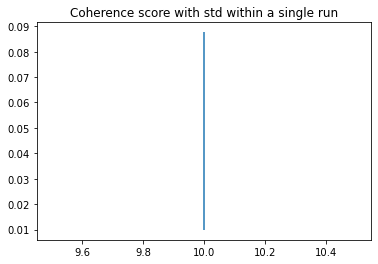

In [9]:
plotting_coherence(eval_df)

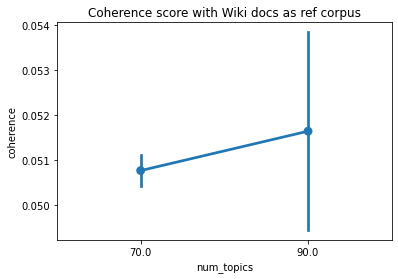

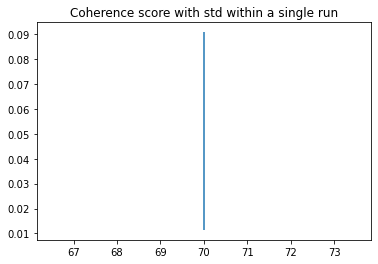

In [26]:
#merge the ranges of coherence.

coherence_10_90 = pd.read_csv('coherence_10to20_st20.csv')
coherence_10_90 = coherence_10_90.append(pd.read_csv('coherence_30to50_st20.csv'))
coherence_10_90 = coherence_10_90.append(pd.read_csv('coherence_35to45_st10.csv'))
coherence_10_90 = coherence_10_90.append(pd.read_csv('coherence_55to55_st10.csv'))
coherence_10_90 = coherence_10_90.append(pd.read_csv('coherence_70to90_st20.csv'))
coherence_10_90 = coherence_10_90.append(pd.read_csv('coherence_36to54_st4.csv'))
coherence_10_90 = coherence_10_90.append(pd.read_csv('coherence_37to43_st2.csv'))
coherence_10_90 = coherence_10_90.append(pd.read_csv('coherence_38to38_st2.csv'))

/share/ceph/scratch/amh418/9576375/ipykernel_2471471/4192381956.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coherence_10_90 = coherence_10_90.append(pd.read_csv('coherence_30to50_st20.csv'))
/share/ceph/scratch/amh418/9576375/ipykernel_2471471/4192381956.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coherence_10_90 = coherence_10_90.append(pd.read_csv('coherence_35to45_st10.csv'))
/share/ceph/scratch/amh418/9576375/ipykernel_2471471/4192381956.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coherence_10_90 = coherence_10_90.append(pd.read_csv('coherence_55to55_st10.csv'))
/share/ceph/scratch/amh418/9576375/ipykernel_2471471/4192381956.py:7: FutureWarning: The frame.append method is deprecated and will be r

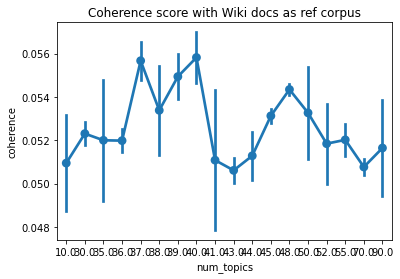

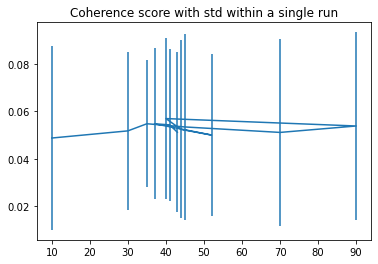

In [27]:
plotting_coherence(coherence_10_90)

In [28]:
coherence_10_90

,Unnamed: 0,num_topics,coherence,purity,contrast,coherence_std
0,0,10.0,0.048751,0.0,0.0,0.038899
1,1,10.0,0.053151,0.0,0.0,0.036071
0,0,30.0,0.052844,0.0,0.0,0.035356
1,1,30.0,0.051777,0.0,0.0,0.033363
2,2,50.0,0.055394,0.0,0.0,0.037120
3,3,50.0,0.051140,0.0,0.0,0.035933
0,0,35.0,0.054793,0.0,0.0,0.026912
1,1,35.0,0.049212,0.0,0.0,0.031974
2,2,45.0,0.052822,0.0,0.0,0.031642
3,3,45.0,0.053437,0.0,0.0,0.039467


In [11]:
# 4. Run LDA based on the topics number found in Step 3.
n_topics = 40; iterations = 2000
ldaMallet = LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=n_topics, id2word=vocab_dict,iterations=iterations,random_seed = 54321,optimize_interval=50)

In [5]:
def get_doc_topics(model,docs,n_topics,doc_number,top_doc_n=10,show_top_doc=False):
  '''
  Computes and shows doc-topic distribution
  -----------------------------------------
  parameters:
  -----------------
  model: A LdaMallet gensim wrapper
  n_topics: number of topics that the model was trained with
  doc_number: number of documents in total
  top_doc_n: number of top documents to show for each topic
  show_top_doc: whether to show top documents for each topic or not

  returns:
  -----------------
  doc_topics_np: a numpy array of size (doc,n_topics) that shows the distribution of topics for each doc
  '''
  #test something
  doc_topics = model.load_document_topics() #loading doc-topic distribution
  doc_topics_np = np.zeros((doc_number,n_topics)) #initializing a numpy array to collect all topic-doc matrices

  docc = 0
  #reading one by one from doc_topics LDA output
  for D in doc_topics:
    doc_topics_np[docc,:] = np.asarray(D)[:,1]
    docc = docc + 1
  #top_doc_n = 10

  if show_top_doc:
    #printing top documents of each topics
    for i in range(doc_topics_np.shape[1]):
      top_doc = np.argsort(doc_topics_np[:,i])[-top_doc_n:]
      print('Topic ', i,' : ',model.show_topic(i))
      print('top docs: \n')
      for ind in reversed(range(len(top_doc))):
        print([doc_topics_np[top_doc[ind],i],docs[top_doc[ind]]])
        print("........----------------........")
      print("------------------------------------------------------------------")
      print('\n\n\n')

  return doc_topics_np

In [27]:
n_topics = 40
doc_topics = get_doc_topics(ldaMallet,originaltext,n_topics,len(doc_term_matrix),top_doc_n=20,show_top_doc=True)

Topic  0  :  [('coronavirus', 0.027304943057911316), ('food', 0.024507057184395446), ('masks', 0.00971498667312818), ('water', 0.007341137630239884), ('ppe', 0.00708747274048946), ('supply', 0.006292403683062758), ('products', 0.006152320087230434), ('delivery', 0.006016022534528713), ('meat', 0.0055124787981584685), ('farmers', 0.005145232614489945)]
top docs: 

[0.9641898563004746, '/n  #Healthy tips to boost your health while under #quarantine #COVID \n-Drink plenty of water\n-Increase intake of fruits &amp; vegetables that rich in \nvitamin C\n-Choose whole grain &amp; pulses\n-Replace saturated with unsaturated fat\n-Add dried herbs &amp; spices in your meal']
........----------------........
[0.9641898563004746, 'Disposable masks, disinfectant, gloves, protective clothing, thermometer and other medical materials, kn, n, M. WhatsApp  WeChat:ssu\n#covid \n#ply \n#mask \n#medical \n#n\n#kn \n#niosh \n#ffp \n#usa \n#china \n#surgical#fda #ce \n#purchase #respirator #dasheng ']
......

In [8]:
with open('doc_topics.obj', 'wb') as objwriter:
    pickle.dump(doc_topics, objwriter)

NameError: name 'doc_topics' is not defined

In [6]:
def topic_top_terms(ldaMallet,n_topics,top_n_terms = 20):
  '''
  gets an LDAMallet model and returns top-terms in a list

  Returns: list of top terms (type:List)

  parameter ldaMallet: Trained Gensim Object for ldaMallet
  '''


  topic_term = []#np.asarray([['sample_string']*top_n]*n_topics)

  # loop through all the topics we have
  for i in range(n_topics):
    text_to_show = ''
    temp_ls = []
    # looping through the number of words we want to represent each topic ==> can do it with an iterator oved show_topic results as well.
    for j in range(top_n_terms): 
      temp_ls.append(ldaMallet.show_topic(i,topn=top_n_terms)[j][0])
    topic_term.append(temp_ls[:])

  return topic_term

In [38]:
#get the top terms for all the topics:
topics_terms_30 = topic_top_terms(ldaMallet,n_topics,top_n_terms = 30)

In [101]:
# topics_terms_30

In [40]:
# topics_terms_30
with open('topics_terms_30', 'wb') as objwriter:
    pickle.dump(topics_terms_30, objwriter)

# Get the data from Data Base 

In [7]:
import mysql.connector

sql_db = mysql.connector.connect(host='127.0.0.1',user = 'covidAnalysis',password = 'k34p63MbDDcZ9yf4',
                                 database = 'covid19framing')

In [8]:
cursor = sql_db.cursor()

In [9]:
cursor.execute('show tables;')
results = cursor.fetchall()
results

[('article_author',),
 ('article_keyword',),
 ('article_organization',),
 ('articles',),
 ('organizations',),
 ('twitter',),
 ('twitter_hashtag',)]

In [10]:
# cursor.execute('desc twitter')
cursor.execute('desc articles')
results = cursor.fetchall()
results

[('id', 'int(11)', 'NO', 'PRI', None, 'auto_increment'),
 ('text', 'mediumtext', 'NO', '', None, ''),
 ('date_published', 'timestamp', 'NO', '', 'CURRENT_TIMESTAMP', ''),
 ('url', 'mediumtext', 'NO', '', None, ''),
 ('title', 'varchar(1000)', 'NO', '', None, ''),
 ('source', 'varchar(60)', 'YES', '', None, ''),
 ('language', 'varchar(2)', 'YES', '', None, ''),
 ('date_scraped', 'timestamp', 'NO', '', 'CURRENT_TIMESTAMP', ''),
 ('state', 'varchar(12)', 'NO', '', None, ''),
 ('text_preproc', 'mediumtext', 'YES', '', None, '')]

In [9]:
# results[0]

# pre process the fetch data and store back to the databse

In [20]:
offset = 0#counter for offset
results = [0] #starting with a non-empty results to make sure we get into loop in the first place

while results:
    cursor.execute("select * from articles where text_preproc is NULL limit 1000 offset {0};".format(offset))
    offset += 1000
    results = cursor.fetchall()
    result_dic = {i[0]:i for i in results}
#     print(type([i[0] for i in results]), type([i[1].decode() for i in results]))
    

    #send to pre_process (...)
    out = preprocess_data([i[1].decode() for i in results], [i[0] for i in results], extra_stopwords,len_th=4,lemmatized=False)
    #out ==> 1. pre_prcesed doc, original, id
    print(type(out))
    #putting it back to DB
    for o in out:
        cursor.execute("update articles SET text_preproc = '{0}' where id = {1}".format(' '.join(o[0]),o[2]))

<class 'list'>
<class 'list'>


In [54]:
# results[0][-1].decode().split()

# Get the original and the pre-process documents and their ids from the DB

In [35]:
cursor.execute("select * from articles where text_preproc is not NULL")
results = cursor.fetchall()

In [33]:
# results[100][-1].decode().split()

In [36]:
doclist = [item[-1].decode().split() for item in results]
originaltext = [item[1].decode() for item in results]

In [18]:
originaltext = [item[1].decode() for item in results]

In [37]:
len(originaltext)

1000

# Prepare the corpus

In [38]:
vocab_dict, doc_term_matrix = prepare_corpus(doclist)

In [24]:
# vocab_dict, doc_term_matrix = prepare_corpus(tokens)

# Run the LDA model 

In [ ]:
n_topics = 15; iterations = 2000
ldaMallet = LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=n_topics, id2word=vocab_dict,iterations=iterations,random_seed = 54321,optimize_interval=50)
doc_topics = get_doc_topics(ldaMallet,originaltext,n_topics,len(doc_term_matrix),top_doc_n=20,show_top_doc=True)
doc_topics